In [1]:
import pandas as pd
import zipfile
!pip install scikit-surprise

from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 11.8MB 327kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617609 sha256=cde01173c752754ab03144eda17b610ec3573e80d49bec72ee4a11f6bc509632
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
!wget https://github.com/bonehead/product_recommendations_case/blob/main/train.zip?raw=true
!wget https://raw.githubusercontent.com/bonehead/product_recommendations_case/main/submission.csv
!mv train.zip?raw=true train.zip
file_to_extract='train.csv'
with zipfile.ZipFile("train.zip") as z:
  with open(file_to_extract, 'wb') as f:
    f.write(z.read(file_to_extract))
    print("Extracted", file_to_extract)

--2021-05-30 13:54:53--  https://github.com/bonehead/product_recommendations_case/blob/main/train.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/bonehead/product_recommendations_case/raw/main/train.zip [following]
--2021-05-30 13:54:53--  https://github.com/bonehead/product_recommendations_case/raw/main/train.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bonehead/product_recommendations_case/main/train.zip [following]
--2021-05-30 13:54:54--  https://raw.githubusercontent.com/bonehead/product_recommendations_case/main/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [3]:
txns=pd.read_csv("train.csv",parse_dates=["InvoiceDate"])
txns.head()

,transaction_id,item_id,item_qty,InvoiceDate,item_amt,customer_id
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0


In [78]:
txns["customer_id"]=txns["customer_id"].apply(str)
txns.head()

,transaction_id,item_id,item_qty,InvoiceDate,item_amt,customer_id
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0


In [79]:
submission=pd.read_csv("submission.csv")
submission.head()

,customer_id,Target_20724,Target_20725,Target_20726,Target_20727,Target_20728,Target_20914,Target_21080,Target_21212,Target_21232,Target_21754,Target_21790,Target_21931,Target_21977,Target_22178,Target_22197,Target_22355,Target_84879,Target_84991,Target_85099B,Target_85099C,Target_85123A
0,12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
dataset=txns.groupby(["customer_id","item_id"], as_index=False)["transaction_id"].count()
dataset.describe()

,transaction_id
count,417208.000000
mean,2.072050
std,8.354119
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1312.000000


In [81]:
dataset.head()

,customer_id,item_id,transaction_id
0,12346.0,15056BL,1
1,12346.0,15056N,1
2,12346.0,15056P,1
3,12346.0,20679,1
4,12346.0,20682,1


### Unique Counts

In [82]:
print('No. of Unique Users    :', dataset["customer_id"].nunique())
print('No. of Unique Business :', dataset["item_id"].nunique())
print('No. of Unique Ratings  :', dataset["transaction_id"].nunique())

No. of Unique Users    : 5502
No. of Unique Business : 5144
No. of Unique Ratings  : 307


### Overall Count of Ratings given by Users

In [83]:
rating_gp = dataset.groupby(by=['transaction_id']).agg({'customer_id': 'count'}).reset_index()
rating_gp.columns = ['Rating', 'Count']

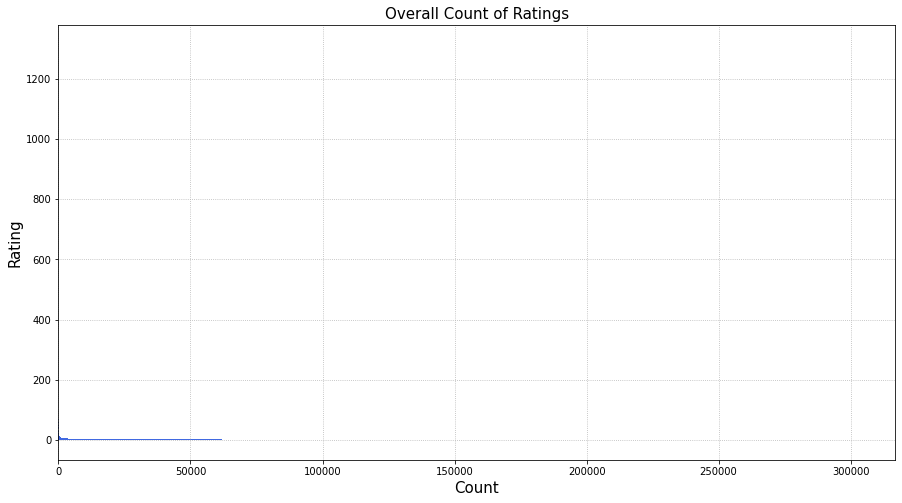

In [84]:
plt.figure(figsize=(15,8))
plt.barh(rating_gp.Rating, rating_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

### There is one user item pair where number of transactions is 120 hence the long tail along Y axis. To identify a good enough limit for transactions we will try and find a suitable cut

In [85]:
dataset[dataset["transaction_id"]>8]

,customer_id,item_id,transaction_id
27,12346.0,M,9
28,12346.0,TEST001,9
3230,12395.0,POST,11
4847,12417.0,POST,17
5136,12422.0,POST,10
...,...,...,...
417194,nan,POST,78
417195,nan,S,93
417198,nan,gift_0001_10,15
417199,nan,gift_0001_20,28


In [86]:
4366/41222*100

10.591431759739944

#### We will rescale about 10.6% of user-item interactions and limit the maximum rating to 8

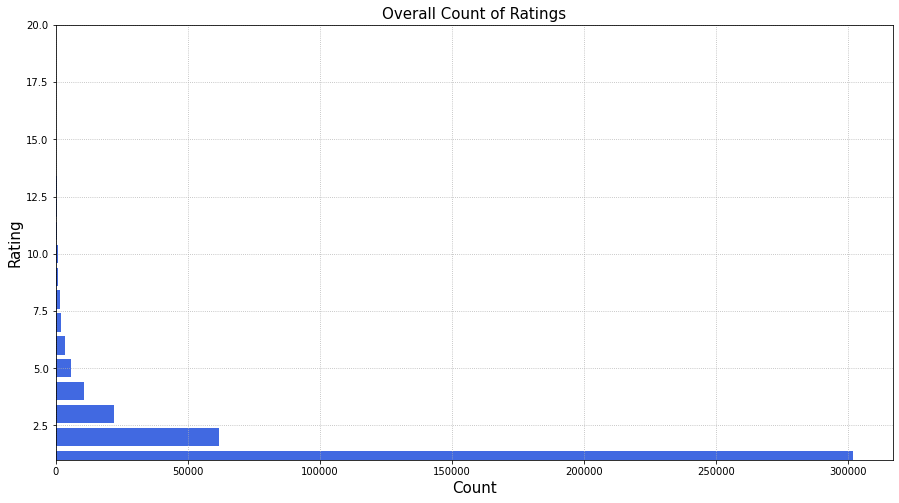

In [87]:
plt.figure(figsize=(15,8))
plt.barh(rating_gp.Rating, rating_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.ylim([1, 20])
plt.show()

In [88]:
maxVal = 8
dataset["scaled_ratings"]=dataset["transaction_id"]
dataset["scaled_ratings"]=dataset['scaled_ratings'].where(dataset['scaled_ratings'] <= maxVal, maxVal)
dataset.head()

,customer_id,item_id,transaction_id,scaled_ratings
0,12346.0,15056BL,1,1
1,12346.0,15056N,1,1
2,12346.0,15056P,1,1
3,12346.0,20679,1,1
4,12346.0,20682,1,1


#### Saving our ratings to a csv file

In [89]:
dataset=dataset[["customer_id","item_id","scaled_ratings"]]
dataset.to_csv("ratings.csv",index=False)

### Lets move on to building a recommender system now

### Memory based Recommender System

#### Choosing between user-user vs item-item matrix

In [90]:
print(dataset["customer_id"].nunique())
print(dataset["item_id"].nunique())

5502
5144


#### As the order of unique values is same 10^3 there isnt much to choose between, if one of these was a order of magnitude lower than the other we would have chosen that to account for sparse representation.

In [91]:
reader = Reader(line_format='user item rating', sep=',',skip_lines=1,rating_scale=(1, 8))
data = Dataset.load_from_file("ratings.csv", reader=reader)

In [92]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=-2, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=-2, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=-2, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### MF Based Recommender Systems

In [93]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=-2, verbose=False)
# svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=-2, verbose=False)  ....Was taking too long need to investigate why
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=-2, verbose=False)

### Other CF Recommender Systems

In [94]:
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=-2, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=-2, verbose=False)

### Results

In [95]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
#print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.3379 	 0.6671
KNN Means 	 1.1045 	 0.6498
KNN ZScore 	 1.0988 	 0.6456

SVD 		 1.043 	 0.621
NMF 		 1.0376 	 0.5954

SlopeOne 	 1.111 	 0.7006
CoClustering 	 1.0848 	 0.6465



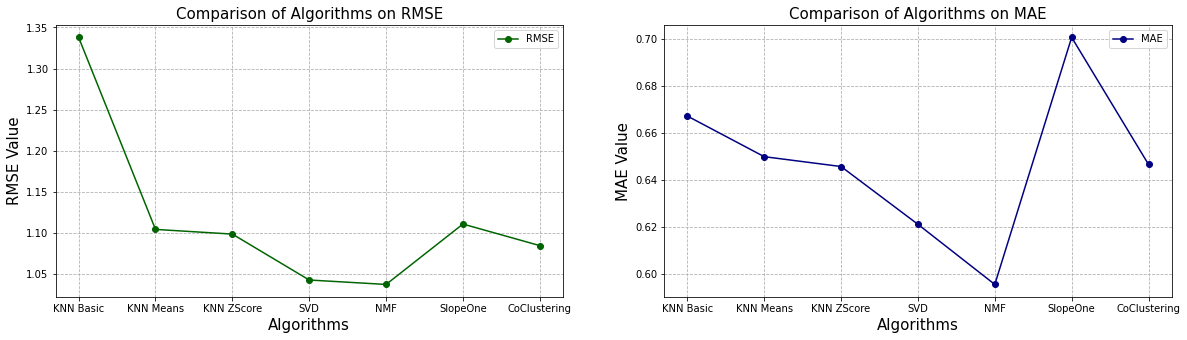

In [96]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD',  'NMF', 'SlopeOne', 'CoClustering']  #Removed 'SVDpp'
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv,  nmf_cv, slope_cv, coclus_cv] #Removed svdpp_cv,

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

### Best model basis RMSE is SVD, NMF being second. Likewise considering MAE NMF is the best model followed by SVD

##### Gridsearch for SVD

In [97]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25],'n_factors':[5, 10,20], ### 'n_factors':[5, 10,20]  Search for number of Latent factors
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)

In [98]:
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))

SVD   - RMSE: 1.144 ; MAE: 0.6781


In [99]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

RMSE = {'n_epochs': 25, 'n_factors': 20, 'lr_all': 0.007, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'n_factors': 20, 'lr_all': 0.01, 'reg_all': 0.4}


##### Retrain model with entire train dataset and identified parameters

In [100]:
algo = svd_gs.best_estimator['rmse']

In [101]:
algo.fit(data.build_full_trainset())

#### Submission

In [138]:
submission=pd.read_csv("submission.csv")
submission.head()

,customer_id,Target_20724,Target_20725,Target_20726,Target_20727,Target_20728,Target_20914,Target_21080,Target_21212,Target_21232,Target_21754,Target_21790,Target_21931,Target_21977,Target_22178,Target_22197,Target_22355,Target_84879,Target_84991,Target_85099B,Target_85099C,Target_85123A
0,12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
items=submission.columns
items=items[1:]
items

Index(['Target_20724', 'Target_20725', 'Target_20726', 'Target_20727',
       'Target_20728', 'Target_20914', 'Target_21080', 'Target_21212',
       'Target_21232', 'Target_21754', 'Target_21790', 'Target_21931',
       'Target_21977', 'Target_22178', 'Target_22197', 'Target_22355',
       'Target_84879', 'Target_84991', 'Target_85099B', 'Target_85099C',
       'Target_85123A'],
      dtype='object')

In [140]:
users=submission.customer_id.unique()
users[:10]

array([12347, 12349, 12352, 12357, 12359, 12362, 12364, 12370, 12371,
       12375])

In [141]:
algo.predict(uid = 12359.0, iid = items[0][7:])

Prediction(uid=12359.0, iid='20724', r_ui=None, est=2.256650712401542, details={'was_impossible': False})

In [142]:
algo.predict(uid = '12359.0', iid = items[0][7:])

Prediction(uid='12359.0', iid='20724', r_ui=None, est=1.892221684717845, details={'was_impossible': False})

In [143]:
algo.predict(uid = '12347.0', iid = items[0][7:])

Prediction(uid='12347.0', iid='20724', r_ui=None, est=2.1884569664035642, details={'was_impossible': False})

In [144]:
col_names =  ['customer_id', 'item_id', 'rating']
preds=pd.DataFrame(columns = col_names)
preds

,customer_id,item_id,rating


In [145]:
for user in users:
  for item in items:
    user1=str(user)+'.0'
    #print(user1)
    rating= algo.predict(uid = user1, iid = item[7:])
    new_row = {'customer_id':user, 'item_id':item, 'rating':rating.est}
    preds = preds.append(new_row, ignore_index=True)


In [146]:
preds.to_csv("predictions.csv",index=False)

In [147]:
predictions_wide=preds.pivot(index='customer_id',columns='item_id',values='rating').reset_index()
predictions_wide.head()

item_id,customer_id,Target_20724,Target_20725,Target_20726,Target_20727,Target_20728,Target_20914,Target_21080,Target_21212,Target_21232,Target_21754,Target_21790,Target_21931,Target_21977,Target_22178,Target_22197,Target_22355,Target_84879,Target_84991,Target_85099B,Target_85099C,Target_85123A
0,12347,2.188457,2.326013,2.181332,2.237343,2.081022,2.334287,1.774823,1.898387,2.477009,2.235752,1.723951,2.351070,1.911276,2.023278,2.183022,2.202436,2.211728,1.934884,2.523626,2.174045,2.632294
1,12349,1.874983,2.012526,1.867869,1.923846,1.767578,2.020892,1.461596,1.585082,2.163679,1.922461,1.410827,2.037386,1.598030,1.710101,1.869703,1.888950,1.898481,1.621634,2.210055,1.860467,2.318958
2,12352,2.234211,2.371757,2.227114,2.283048,2.126857,2.380140,1.821016,1.944410,2.522972,2.281837,1.770316,2.396468,1.957388,2.069517,2.228965,2.248135,2.257880,1.980994,2.569197,2.219614,2.678241
3,12357,1.776543,1.914091,1.769443,1.825396,1.669175,1.922520,1.363365,1.486786,2.065333,1.824190,1.312687,1.938772,1.499780,1.611918,1.771390,1.790511,1.800266,1.523394,2.111561,1.761960,2.220648
4,12359,1.892222,2.029770,1.885114,1.941073,1.784839,2.038184,1.478994,1.602430,2.180985,1.939830,1.428293,2.054489,1.615409,1.727537,1.887042,1.906184,1.915883,1.639012,2.227250,1.877643,2.336294


In [148]:
predictions_wide.to_csv("predictions_wide.csv",index=False)

##### Order ratings for each user  and pick top 3

In [127]:
preds1=preds.groupby(['customer_id']).apply(lambda x: x.sort_values('rating',ascending=False)).reset_index(drop=True)
preds1.head()

,customer_id,item_id,rating
0,12347,Target_85123A,2.632294
1,12347,Target_85099B,2.523626
2,12347,Target_21232,2.477009
3,12347,Target_21931,2.351070
4,12347,Target_20914,2.334287


In [130]:
preds1=preds1.groupby(['customer_id']).head(3).reset_index(drop=True)
preds1.head()

,customer_id,item_id,rating
0,12347,Target_85123A,2.632294
1,12347,Target_85099B,2.523626
2,12347,Target_21232,2.477009
3,12349,Target_85123A,2.318958
4,12349,Target_85099B,2.210055


In [132]:
predictions_wide=preds1.pivot(index='customer_id',columns='item_id',values='rating').reset_index()
predictions_wide.head()

item_id,customer_id,Target_21232,Target_85099B,Target_85123A
0,12347,2.477009,2.523626,2.632294
1,12349,2.163679,2.210055,2.318958
2,12352,2.522972,2.569197,2.678241
3,12357,2.065333,2.111561,2.220648
4,12359,2.180985,2.227250,2.336294
